In [1]:
import pandas as pd
import numpy as np
import alphalens
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass
import empyrical

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir('../')

In [4]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.导入数据

In [5]:
# alpha = pd.read_csv('./Output/alpha_daily_return(5%Significance).csv',index_col = 0)
# alpha = pd.read_csv('./Output/alpha_style_index(5%Significance).csv',index_col = 0)
alpha = pd.read_csv('./Output/alpha_style_index(all).csv',index_col = 0)
alpha.index = pd.to_datetime(alpha.index)

In [6]:
# 导入净值数据
# 基金数据，并分类到股票型基金
nv_2010to2014 = pd.read_csv("./Data/AdjustedNav(2010to2014).csv",index_col = 0)
nv_2015to2018 = pd.read_csv("./Data/AdjustedNav(2015to2018).csv",index_col = 0)
nv_2019to2022 = pd.read_csv("./Data/AdjustedNav(2019to2022).csv",index_col = 0)

In [7]:
nv = pd.concat([nv_2010to2014,nv_2015to2018,nv_2019to2022])

In [8]:
nv.index = pd.to_datetime(nv.index)

In [9]:
filled_nv = nv.asfreq("D").ffill()

In [10]:
# 导入基金经理离任数据
manager_info = pd.read_csv("./Data/ChinaMutualFundManager.csv",encoding = "gbk")

In [11]:
# 导入货币市场基金，不买货币市场基金
# 导入股票型、偏股型和灵活配置型基金
currency_fund = pd.read_excel("./Data/CurrencyFund.xlsx",index_col = 0)
stk_mutual_fund = pd.read_excel("./Data/StkMutualFundInfo.xlsx",index_col = 0)

In [12]:
stk_mutual_fund.query("FUND_TYPE == '普通股票型基金' or FUND_TYPE == '偏股混合型基金'",inplace = True)

#### 2.回测

In [13]:
@dataclass
class FundClass:
    vt_symbol:str = " "
    buy_price:float = 0.0
    volume:int = 0
        
    def __post_init__(self):
        self.price = self.buy_price
        self.last_price = self.buy_price
        self.pnl = (self.price - self.buy_price)*self.volume
        self.daily_pnl = (self.price - self.last_price)*self.volume
        self.status = "HOLDING"

In [14]:
"""variables"""

"""paramaters"""
start_date = pd.to_datetime("2013-12-31")
end_date = pd.to_datetime("2022-03-31")
buy_cost:float = 0.005
sell_cost:float = 0.005
"""account infomation"""
in_position_fund:dict = {} 
balance:float = 300000.0
backtest_result:pd.DataFrame = pd.DataFrame(columns = ["ACCOUNT_NAV"])

In [15]:
for date in pd.date_range(start_date,end_date): # 每天都进行循环更新
    
    if date in alpha.index and date.month % 3 == 0:
        # seasonal adjustment
#         to_buy_position = alpha.loc[date].dropna() # alpha > 0 version
        to_buy_position = alpha.loc[date].dropna().sort_values(ascending = False).iloc[:int(len(alpha.loc[date].dropna())*0.1)] # all alpha version
        # clear
        for to_sell_fund in in_position_fund.keys():
            # update when at the end of the month
            in_position_fund[to_sell_fund].last_price = in_position_fund[to_sell_fund].price
            in_position_fund[to_sell_fund].price = filled_nv.at[date,to_sell_fund]
            in_position_fund[to_sell_fund].pnl = (in_position_fund[to_sell_fund].price - \
                                                  in_position_fund[to_sell_fund].buy_price)*in_position_fund[to_sell_fund].volume
            in_position_fund[to_sell_fund].daily_pnl = (in_position_fund[to_sell_fund].price - \
                                                        in_position_fund[to_sell_fund].last_price)*in_position_fund[to_sell_fund].volume
            # sell
            if to_sell_fund not in to_buy_position:
                sell_price = filled_nv.at[date,to_sell_fund]
                print(f"sell {to_sell_fund} at {sell_price}")
                in_position_fund[to_sell_fund].status = "SOLD"
        
        # adjust
        for to_adjust_fund in in_position_fund.keys():
            if in_position_fund[to_adjust_fund].status == "HOLDING":
                price = filled_nv.at[date,to_adjust_fund]
                target_volume = balance/len(to_buy_position)/(price*(1+sell_cost))
                present_volume = in_position_fund[to_adjust_fund].volume
                if target_volume > present_volume:
                    pass
                else:
                    balance += (present_volume - target_volume)*(price - in_position_fund[to_adjust_fund].last_price)
                    balance -= (present_volume - target_volume)*price*sell_cost # sell cost
                    in_position_fund[to_adjust_fund].volume = target_volume
                    in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                            in_position_fund[to_adjust_fund].buy_price) * in_position_fund[to_adjust_fund].volume
                    in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                                  in_position_fund[to_adjust_fund].last_price) * in_position_fund[to_adjust_fund].volume
                    print(f"adjust {to_adjust_fund} from {present_volume} to {target_volume}")

        # buy
        for to_buy_fund in to_buy_position.index:
            if to_buy_fund not in in_position_fund.keys() and to_buy_fund not in currency_fund.index:
                buy_price = filled_nv.at[date,to_buy_fund]
                in_position_fund[to_buy_fund] = FundClass(
                    vt_symbol = to_buy_fund,
                    buy_price = buy_price,
                    volume = balance/len(to_buy_position)/(buy_price*(1+buy_cost)),
                )
                balance -= buy_price*(balance/len(to_buy_position)/buy_price)*buy_cost # buy cost
                print(f"buy {to_buy_fund} at {buy_price}")
                
    else:
        # 平日更新
        for to_adjust_fund in in_position_fund.keys():
            price = filled_nv.at[date,to_adjust_fund]
            in_position_fund[to_adjust_fund].last_price = in_position_fund[to_adjust_fund].price
            in_position_fund[to_adjust_fund].price = price
            in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                    in_position_fund[to_adjust_fund].buy_price)*in_position_fund[to_adjust_fund].volume
            in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                          in_position_fund[to_adjust_fund].last_price)*in_position_fund[to_adjust_fund].volume
            
    for to_compute_pnl_fund in list(in_position_fund.keys()):
        balance += in_position_fund[to_compute_pnl_fund].daily_pnl
        if in_position_fund[to_compute_pnl_fund].status == "SOLD":
            balance -= in_position_fund[to_compute_pnl_fund].price*in_position_fund[to_compute_pnl_fund].volume*sell_cost # sell cost
            del in_position_fund[to_compute_pnl_fund]
    backtest_result.loc[date,"ACCOUNT_NAV"] = balance

buy 590005.OF at 1.0888
buy 040005.OF at 3.16694003
buy 165512.OF at 1.311
buy 180031.OF at 1.3549
buy 080012.OF at 1.6345
buy 090007.OF at 1.9905
buy 550009.OF at 1.0756
buy 160512.OF at 1.2153
buy 166009.OF at 1.159
buy 420005.OF at 1.1328
buy 206009.OF at 1.233
buy 213008.OF at 1.59387543
buy 210004.OF at 0.9826
buy 163409.OF at 1.315
buy 160613.OF at 1.4036
buy 519679.OF at 1.926
buy 233009.OF at 1.101
buy 871003.OF at 3.24529727
buy 162202.OF at 5.01404917
buy 110029.OF at 2.67211416
buy 240009.OF at 2.18554704
buy 100056.OF at 1.162
buy 163110.OF at 1.058
buy 180010.OF at 3.31222976
buy 240017.OF at 1.4636
buy 166005.OF at 1.113
buy 320016.OF at 0.951
buy 880007.OF at 1.45616981
buy 290005.OF at 1.72039744
buy 070010.OF at 2.7662612
buy 900010.OF at 1.193
buy 519670.OF at 2.0338
buy 630011.OF at 1.595
buy 270007.OF at 0.6969
buy 040025.OF at 1.439
buy 000251.OF at 1.086
buy 630016.OF at 1.3587
buy 163406.OF at 1.1675
buy 213006.OF at 1.3156376
buy 920002.OF at 2.19302514
buy 1606

sell 213008.OF at 2.39578512
sell 233009.OF at 1.5049
sell 630011.OF at 2.3446
sell 100039.OF at 1.1982
sell 166019.OF at 1.415
sell 166009.OF at 1.5111
sell 000550.OF at 1.69
sell 519702.OF at 0.969
sell 160505.OF at 8.49306497
sell 580005.OF at 1.28310437
sell 213006.OF at 2.36965566
sell 202027.OF at 1.3658
sell 000017.OF at 1.8696
sell 460009.OF at 1.0144
sell 519983.OF at 1.34
sell 000535.OF at 1.409
sell 420005.OF at 1.4155
sell 519678.OF at 1.421
sell 519158.OF at 1.324
sell 630015.OF at 1.8482
sell 420003.OF at 1.5875
sell 910028.OF at 1.3565
sell 202009.OF at 1.09687746
sell 580001.OF at 3.08964162
sell 206012.OF at 0.997
sell 000534.OF at 1.372
sell 000551.OF at 1.373
sell 740001.OF at 1.692
sell 310388.OF at 1.1262
sell 050014.OF at 1.2417
sell 217012.OF at 1.274
sell 160127.OF at 1.2378
sell 310308.OF at 4.17955689
sell 000594.OF at 1.249
sell 160314.OF at 4.52803857
sell 160603.OF at 5.43738994
sell 000263.OF at 1.653
sell 519091.OF at 1.397
sell 217010.OF at 2.18245809
se

sell 000574.OF at 1.7359
sell 519158.OF at 1.91
sell 000584.OF at 1.545
sell 000717.OF at 1.048
sell 910024.OF at 1.66935216
sell 000663.OF at 1.9861
sell 000739.OF at 1.406
sell 000410.OF at 2.189
sell 519156.OF at 2.183
sell 519120.OF at 1.983
sell 970016.OF at 1.71004959
sell 880007.OF at 2.21245774
sell 762001.OF at 2.63093019
sell 000404.OF at 2.129
sell 000646.OF at 1.16
sell 673010.OF at 1.744
sell 000273.OF at 1.79
sell 000729.OF at 1.339
sell 519969.OF at 1.264
sell 100056.OF at 2.55
sell 519095.OF at 2.4581
sell 399011.OF at 1.5098
sell 870005.OF at 0.9683
sell 900011.OF at 1.71554632
sell 000124.OF at 1.8766
sell 000822.OF at 1.171
sell 233009.OF at 1.9432
sell 000220.OF at 1.814
sell 400011.OF at 1.275
sell 160512.OF at 1.8009
sell 000619.OF at 1.812
sell 519097.OF at 2.002
sell 630002.OF at 4.4298
sell 070022.OF at 1.923
sell 400007.OF at 2.1774
sell 630010.OF at 2.5117
sell 000878.OF at 1.078
sell 519983.OF at 1.599
sell 240020.OF at 1.8984
sell 400001.OF at 4.24969361
se

sell 040035.OF at 3.3265
sell 001154.OF at 0.994
sell 519993.OF at 3.1364825
sell 161224.OF at 1.1358
sell 001255.OF at 0.757
sell 519704.OF at 2.235
sell 040016.OF at 1.8353
sell 200010.OF at 2.1912
sell 519918.OF at 1.4305
sell 519957.OF at 1.006
sell 210004.OF at 1.941
sell 233007.OF at 2.31
sell 000924.OF at 1.131
sell 213001.OF at 4.1049919
sell 610002.OF at 2.06603014
sell 519156.OF at 2.3407
sell 257050.OF at 1.519
sell 213006.OF at 2.46639951
sell 233011.OF at 1.9981
sell 200015.OF at 1.6291
sell 630001.OF at 2.1602395
sell 590005.OF at 1.9533
sell 610005.OF at 1.1011
sell 000309.OF at 1.488
sell 290011.OF at 2.1077
sell 080005.OF at 1.9598
sell 630011.OF at 2.7059
sell 000955.OF at 1.229
sell 001445.OF at 1.024
sell 630005.OF at 2.268
sell 000706.OF at 1.196
sell 000209.OF at 1.816
sell 001042.OF at 0.747
sell 202009.OF at 1.47839705
sell 000965.OF at 0.8519
sell 519979.OF at 2.0995
sell 000966.OF at 0.961
sell 000294.OF at 1.523
sell 630016.OF at 2.0631
sell 000800.OF at 1.17

sell 001071.OF at 1.12
sell 519975.OF at 1.4816
sell 161225.OF at 1.027
sell 001449.OF at 1.213
sell 519965.OF at 1.249
sell 110025.OF at 0.92
sell 001938.OF at 1.2678
sell 240022.OF at 1.203
sell 001705.OF at 1.133
sell 001302.OF at 1.194
sell 360010.OF at 1.7306
sell 168101.OF at 1.337
sell 210009.OF at 1.5856
sell 580005.OF at 1.56013341
sell 020001.OF at 10.50221072
sell 001140.OF at 0.969
sell 001224.OF at 1.073
sell 160215.OF at 1.7843
sell 001279.OF at 0.869
sell 360016.OF at 2.0183
sell 000308.OF at 2.287
sell 100022.OF at 7.495154
sell 519710.OF at 1.173
sell 000960.OF at 1.022
sell 180012.OF at 3.68383902
sell 000866.OF at 1.354
sell 000294.OF at 1.658
sell 050014.OF at 2.0109
sell 001864.OF at 1.074
sell 050018.OF at 1.063
sell 519704.OF at 2.602
sell 001054.OF at 0.969
sell 001701.OF at 1.012
sell 000336.OF at 1.4859
sell 398061.OF at 2.5522
sell 000039.OF at 1.9097
sell 002168.OF at 1.226
sell 000991.OF at 0.957
sell 040035.OF at 3.7029
sell 270008.OF at 3.41271981
sell 00

sell 519983.OF at 2.6314
sell 000628.OF at 1.268
sell 519702.OF at 1.7314
sell 001421.OF at 1.284
sell 410009.OF at 1.0863
sell 210004.OF at 2.5367
sell 519688.OF at 5.54353682
sell 000523.OF at 1.7234
sell 000362.OF at 2.1882
sell 000520.OF at 1.9133
sell 519712.OF at 2.2944
sell 202019.OF at 1.6063
sell 519697.OF at 3.186
sell 002210.OF at 1.214
sell 519993.OF at 3.42106515
sell 160512.OF at 2.6362
sell 540006.OF at 2.9046
sell 001564.OF at 1.246
sell 001662.OF at 1.13
sell 519727.OF at 1.4379
sell 001897.OF at 1.123
sell 000646.OF at 1.319
sell 000963.OF at 1.311
sell 001056.OF at 0.962
sell 519172.OF at 1.073
sell 001917.OF at 1.1027
sell 233009.OF at 2.8119
sell 519125.OF at 1.571
sell 000471.OF at 2.5021
sell 519120.OF at 2.302
sell 001154.OF at 1.093
sell 001449.OF at 1.279
sell 320012.OF at 1.7766
sell 040015.OF at 2.1556
sell 000458.OF at 1.3695
sell 580007.OF at 1.4942
sell 001186.OF at 0.809
sell 450011.OF at 1.21
sell 450007.OF at 1.5443
sell 519113.OF at 2.0618
sell 001349

sell 519091.OF at 2.673
sell 169101.OF at 2.6855
sell 519156.OF at 3.036
sell 110022.OF at 2.004
sell 001112.OF at 1.44
sell 620006.OF at 1.087
sell 001986.OF at 1.343
sell 200015.OF at 2.1473
sell 000457.OF at 2.4361
sell 376510.OF at 1.718
sell 519979.OF at 2.5571
sell 377010.OF at 6.56862732
sell 001048.OF at 1.358
sell 370027.OF at 2.055
sell 001583.OF at 1.243
sell 100056.OF at 2.801
sell 090004.OF at 7.43760074
sell 910024.OF at 3.00384395
sell 001323.OF at 1.122
sell 519710.OF at 1.4658
sell 090009.OF at 1.581
sell 310358.OF at 2.63816748
sell 001144.OF at 0.853
sell 001222.OF at 0.946
sell 340008.OF at 3.5281
sell 519066.OF at 3.96694662
sell 000328.OF at 1.828
sell 169103.OF at 1.5081
sell 002259.OF at 1.267
sell 373010.OF at 4.39677098
sell 375010.OF at 6.51535455
sell 000577.OF at 2.743
sell 260103.OF at 4.99625516
sell 160212.OF at 2.882
sell 260116.OF at 3.1638
sell 160211.OF at 4.1525
sell 001645.OF at 1.571
sell 570008.OF at 2.60575729
sell 000063.OF at 1.879
sell 001753

sell 001694.OF at 1.503
sell 002229.OF at 1.289
sell 001410.OF at 1.486
sell 001125.OF at 0.796
sell 377240.OF at 2.948
sell 000073.OF at 1.372
sell 001542.OF at 2.039
sell 519606.OF at 2.1669
sell 377020.OF at 1.91730544
sell 020026.OF at 3.8505
sell 000020.OF at 2.219
sell 519033.OF at 2.1274
sell 000742.OF at 2.9211
sell 160215.OF at 2.2405
sell 020001.OF at 13.14838018
sell 100060.OF at 2.4019
sell 001018.OF at 1.617
sell 002692.OF at 1.044
sell 162607.OF at 5.09410897
sell 260101.OF at 10.14295214
sell 519196.OF at 1.469
sell 003940.OF at 1.4732
sell 519195.OF at 1.5762
sell 519005.OF at 3.03914059
sell 003670.OF at 1.0711
sell 001740.OF at 1.465
sell 000601.OF at 1.2137
sell 377530.OF at 2.1947
sell 379010.OF at 2.1385
sell 370024.OF at 2.996
sell 160627.OF at 1.3242
sell 000925.OF at 1.217
sell 000755.OF at 1.2625
sell 000219.OF at 1.4856
sell 001313.OF at 0.75
sell 003154.OF at 1.2997
sell 001897.OF at 1.1861
sell 001967.OF at 1.126
sell 110029.OF at 3.66690332
sell 000612.OF a

sell 001975.OF at 1.667
sell 002803.OF at 1.722
sell 169105.OF at 1.69
sell 350005.OF at 2.1127
sell 040015.OF at 2.4483
sell 519778.OF at 1.1748
sell 210008.OF at 1.7161
sell 660010.OF at 1.1367
sell 519704.OF at 3.1035
sell 004263.OF at 1.275
sell 100020.OF at 11.058774
sell 001076.OF at 1.005
sell 001186.OF at 1.068
sell 519736.OF at 2.5329
sell 000029.OF at 2.0417
sell 000634.OF at 1.9428
sell 519727.OF at 1.3879
sell 163411.OF at 1.90565466
sell 001215.OF at 0.921
sell 206002.OF at 1.441
sell 180013.OF at 3.3442
sell 003119.OF at 1.243
sell 519019.OF at 5.58312761
sell 090013.OF at 2.674
sell 090007.OF at 4.7053
sell 001915.OF at 1.017
sell 001759.OF at 1.208
sell 003886.OF at 1.2431
sell 070022.OF at 2.6817
sell 001838.OF at 0.797
sell 001266.OF at 1.0337
sell 260115.OF at 1.8785
sell 260108.OF at 3.25688983
sell 260104.OF at 9.16372112
sell 001800.OF at 1.098
sell 000654.OF at 1.0791
sell 260109.OF at 4.36355703
sell 162605.OF at 9.08736954
sell 110022.OF at 2.214
sell 000800.OF

sell 001985.OF at 1.262
sell 169104.OF at 1.6159
sell 001605.OF at 1.153
sell 000584.OF at 1.957
sell 000991.OF at 1.13
sell 000531.OF at 1.317
sell 001717.OF at 1.585
sell 004986.OF at 1.2191
sell 000523.OF at 1.8294
sell 001223.OF at 1.061
sell 002424.OF at 1.009
sell 004505.OF at 1.074
sell 004616.OF at 0.9771
sell 001171.OF at 0.865
sell 519091.OF at 2.623
sell 160918.OF at 2.0487
sell 519008.OF at 11.51451561
sell 519087.OF at 5.8754798
sell 001227.OF at 0.569
sell 590008.OF at 3.24
sell 519212.OF at 1.0118
sell 001518.OF at 1.9684
sell 519191.OF at 1.1271
sell 519196.OF at 1.5459
sell 000697.OF at 1.24
sell 004075.OF at 1.2881
sell 519185.OF at 2.269
sell 501001.OF at 1.109
sell 000404.OF at 2.139
sell 003284.OF at 1.0679
sell 519195.OF at 1.6034
sell 003238.OF at 0.9155
sell 470028.OF at 1.655
sell 000831.OF at 1.634
sell 519193.OF at 1.212
sell 121002.OF at 5.70275505
sell 002244.OF at 1.0464
sell 002152.OF at 1.115
sell 000652.OF at 1.7443
sell 001364.OF at 0.932
sell 002252.O

sell 519772.OF at 1.399
sell 399011.OF at 2.32992103
sell 000878.OF at 1.508
sell 003095.OF at 1.32783804
sell 000220.OF at 1.957
sell 000924.OF at 1.10823425
sell 004851.OF at 1.1031
sell 001417.OF at 1.02
sell 001508.OF at 1.435
sell 005176.OF at 1.211
sell 001766.OF at 0.937
sell 004905.OF at 1.084
sell 001558.OF at 0.7971
sell 000960.OF at 1.142
sell 000219.OF at 1.37260661
sell 002137.OF at 1.0982
sell 470006.OF at 1.60977666
sell 161616.OF at 1.52325272
sell 000432.OF at 1.451
sell 213001.OF at 4.59814563
sell 630002.OF at 3.71502575
sell 163001.OF at 1.40276837
sell 460005.OF at 3.71685372
sell 000884.OF at 1.279
sell 000913.OF at 1.0564
sell 690004.OF at 1.579
sell 020001.OF at 11.66794815
sell 002708.OF at 1.129
sell 160215.OF at 1.99884788
sell 519171.OF at 0.751
sell 001970.OF at 0.772
sell 000727.OF at 0.997
sell 163415.OF at 2.44834834
sell 002259.OF at 1.101
sell 002482.OF at 1.058
sell 001167.OF at 0.594
sell 001366.OF at 0.659
sell 161722.OF at 1.065
sell 160603.OF at 6

sell 519961.OF at 0.8935
sell 519697.OF at 3.53582598
sell 519712.OF at 2.61090502
sell 001268.OF at 0.458
sell 519698.OF at 1.36707582
sell 519005.OF at 2.34156008
sell 519767.OF at 0.892558
sell 519773.OF at 0.653
sell 410003.OF at 0.93709503
sell 004890.OF at 0.735
sell 161606.OF at 3.21937328
sell 005495.OF at 0.7339
sell 002229.OF at 1.15578982
sell 121003.OF at 1.84709251
sell 003516.OF at 0.9166
sell 002863.OF at 0.979
sell 398041.OF at 0.98727521
sell 000698.OF at 1.177
sell 001707.OF at 0.769
sell 005001.OF at 0.9651
sell 001513.OF at 0.975
sell 166301.OF at 2.102
sell 200015.OF at 1.70284398
sell 001924.OF at 0.692
sell 003670.OF at 0.6676
sell 001500.OF at 1.16336529
sell 270050.OF at 1.763
sell 001877.OF at 0.684
sell 000339.OF at 1.3263
sell 000739.OF at 0.823
sell 001463.OF at 0.661
sell 001287.OF at 1.1975
sell 000124.OF at 1.50568938
sell 257070.OF at 1.29475978
sell 001534.OF at 0.65
sell 070002.OF at 11.56425819
sell 320005.OF at 1.79867911
sell 002563.OF at 0.969
sel

sell 290012.OF at 1.60220947
sell 001938.OF at 2.04426392
sell 001811.OF at 1.46210021
sell 166019.OF at 2.54059224
sell 000794.OF at 1.303
sell 398011.OF at 2.87183891
sell 001574.OF at 1.039
sell 001410.OF at 1.70860597
sell 002980.OF at 1.092
sell 000965.OF at 0.8412
sell 540010.OF at 1.8527
sell 580001.OF at 3.20205061
sell 004616.OF at 1.32
sell 610002.OF at 3.1777527
sell 003053.OF at 1.104
sell 002692.OF at 1.171
sell 501046.OF at 1.1554
sell 720001.OF at 2.51184908
sell 001701.OF at 1.101
sell 000601.OF at 1.2452375
sell 001480.OF at 0.97
sell 217021.OF at 2.166
sell 000689.OF at 1.10477439
sell 002780.OF at 1.1155
sell 005209.OF at 0.9543
sell 001714.OF at 1.686
sell 002939.OF at 1.23378496
sell 000263.OF at 1.86858336
sell 003853.OF at 1.47453389
sell 003304.OF at 1.214
sell 002168.OF at 1.466
sell 002558.OF at 1.372
sell 001616.OF at 1.339
sell 003984.OF at 1.0879
sell 004314.OF at 1.1372
sell 004496.OF at 1.2814
sell 004640.OF at 0.7991
sell 005037.OF at 0.8146
sell 003834.

sell 001071.OF at 1.26
sell 002620.OF at 1.337
sell 162201.OF at 8.65279716
sell 519115.OF at 1.581
sell 519778.OF at 1.3669
sell 001955.OF at 1.358
sell 673010.OF at 1.48433944
sell 519727.OF at 1.62495817
sell 001424.OF at 1.5651
sell 001449.OF at 1.19950242
sell 002407.OF at 1.47496832
sell 004505.OF at 1.414
sell 005711.OF at 1.3734
sell 360016.OF at 2.08405815
sell 206009.OF at 2.51885551
sell 001215.OF at 0.955
sell 001103.OF at 1.64961984
sell 001518.OF at 2.29473666
sell 001445.OF at 1.581
sell 100060.OF at 2.39443095
sell 519191.OF at 1.27757412
sell 001278.OF at 1.60943822
sell 001178.OF at 1.61255708
sell 460007.OF at 1.703
sell 519212.OF at 1.1701
sell 001141.OF at 1.442
sell 001398.OF at 0.846
sell 002424.OF at 1.108
sell 002281.OF at 1.0615
sell 519185.OF at 2.53968854
sell 001856.OF at 1.221
sell 001782.OF at 1.39598248
sell 002634.OF at 0.756
sell 001224.OF at 1.38
sell 000612.OF at 1.93872833
sell 004694.OF at 0.9235
sell 003516.OF at 1.2515
sell 519110.OF at 1.5060929

sell 070021.OF at 1.861
sell 000985.OF at 1.238
sell 161818.OF at 1.4286407
sell 090019.OF at 1.7336424
sell 519002.OF at 2.20536032
sell 001694.OF at 1.8962295
sell 000308.OF at 2.742
sell 164205.OF at 1.4873
sell 952009.OF at 3.6119725
sell 005106.OF at 1.2753
sell 519915.OF at 1.566
sell 005585.OF at 1.3574
sell 210005.OF at 1.417
sell 000971.OF at 0.91
sell 398061.OF at 3.2448805
sell 000083.OF at 4.426
sell 270022.OF at 1.0149803
sell 398021.OF at 0.94995651
sell 003889.OF at 2.2816
sell 005264.OF at 1.3103
sell 001070.OF at 1.391
sell 001298.OF at 1.128
sell 260109.OF at 6.08500426
sell 005379.OF at 1.2776
sell 005117.OF at 0.7761
sell 003940.OF at 1.66048789
sell 000294.OF at 2.74082105
sell 003634.OF at 1.2445
sell 260108.OF at 4.50316191
sell 000854.OF at 2.093
sell 162605.OF at 12.23249693
sell 260104.OF at 12.90879476
sell 001832.OF at 1.253
sell 110022.OF at 2.886
sell 160605.OF at 7.49027262
sell 006100.OF at 1.5208
sell 005630.OF at 1.2367
sell 000727.OF at 1.417
sell 004

sell 673060.OF at 1.3555335
sell 161903.OF at 5.56607815
sell 050022.OF at 2.71558127
sell 050026.OF at 2.55013975
sell 050010.OF at 2.91183321
sell 001959.OF at 0.943
sell 001508.OF at 2.234
sell 005541.OF at 1.54970046
sell 006154.OF at 1.7433
sell 004851.OF at 1.7051
sell 005176.OF at 1.7575
sell 002692.OF at 1.544
sell 050014.OF at 2.28480934
sell 460005.OF at 5.9230234
sell 001965.OF at 1.216
sell 001839.OF at 1.21323173
sell 610005.OF at 1.24878754
sell 257070.OF at 2.40785247
sell 002408.OF at 1.306
sell 005453.OF at 1.2992
sell 005682.OF at 1.3558
sell 001766.OF at 1.426
sell 004075.OF at 1.7614
sell 004476.OF at 1.399
sell 001915.OF at 1.163
sell 398011.OF at 3.65646888
sell 040015.OF at 3.07542427
sell 004374.OF at 1.54990197
sell 001645.OF at 2.152
sell 005169.OF at 1.4158
sell 163809.OF at 1.77203333
sell 501046.OF at 1.4663
sell 001480.OF at 1.252
sell 005689.OF at 1.5785993
sell 006981.OF at 1.2268
sell 000690.OF at 1.219
sell 720001.OF at 3.23140985
sell 006502.OF at 1.3

sell 161810.OF at 2.380678
sell 005911.OF at 2.38002206
sell 519674.OF at 4.5074
sell 002939.OF at 2.16342903
sell 003745.OF at 1.7057
sell 001809.OF at 1.4048
sell 003984.OF at 1.369
sell 006879.OF at 1.5012
sell 001071.OF at 1.863
sell 001643.OF at 1.2141
sell 005094.OF at 1.1679
sell 005668.OF at 1.1943
sell 001410.OF at 2.66936906
sell 005726.OF at 1.4818
sell 320007.OF at 1.88274843
sell 000404.OF at 2.978
sell 001471.OF at 1.4838431
sell 161611.OF at 1.45328846
sell 006768.OF at 1.0922
sell 003961.OF at 1.6611
sell 161225.OF at 1.56710554
sell 163822.OF at 2.18037368
sell 005962.OF at 1.7531
sell 005495.OF at 1.4078
sell 002849.OF at 1.27637077
sell 002482.OF at 1.779
sell 000584.OF at 2.914
sell 161605.OF at 4.63560561
sell 519700.OF at 3.18118537
sell 001266.OF at 1.1515
sell 519773.OF at 1.368
sell 006822.OF at 1.1059
sell 161912.OF at 1.37259048
sell 160642.OF at 1.1371
sell 000586.OF at 1.775
sell 005569.OF at 1.0976
sell 163807.OF at 3.27936455
sell 006736.OF at 1.3866
sell

sell 000717.OF at 2.826
sell 162703.OF at 12.60013096
sell 005760.OF at 2.0529
sell 519704.OF at 4.84086643
sell 005914.OF at 1.6996
sell 000556.OF at 2.5869634
sell 005825.OF at 2.103
sell 160106.OF at 9.15121273
sell 002621.OF at 2.82
sell 160518.OF at 1.67
sell 004634.OF at 1.657
sell 007484.OF at 1.5593
sell 162201.OF at 13.21183917
sell 007012.OF at 1.47370245
sell 000972.OF at 1.422
sell 003751.OF at 1.4094
sell 920003.OF at 3.53412191
sell 168501.OF at 1.5385
sell 000362.OF at 4.25139187
sell 001543.OF at 2.269
sell 006392.OF at 1.8396
sell 005106.OF at 1.9173
sell 001252.OF at 1.563
sell 003634.OF at 1.7713
sell 007777.OF at 1.3333
sell 006002.OF at 2.7844
sell 001717.OF at 3.371
sell 001171.OF at 1.673
sell 001915.OF at 2.045
sell 002264.OF at 2.199
sell 001880.OF at 1.6896
sell 398041.OF at 2.07222606
sell 003230.OF at 2.61528891
sell 002408.OF at 2.2087
sell 005176.OF at 2.9071
sell 000831.OF at 3.04
sell 161616.OF at 3.36580797
sell 161903.OF at 9.07159886
sell 003304.OF at

buy 003069.OF at 1.3471
buy 001072.OF at 1.76333805
buy 007468.OF at 1.2447
buy 006366.OF at 1.9648
buy 002251.OF at 1.021
buy 257010.OF at 6.35739639
buy 005004.OF at 1.401
buy 450010.OF at 1.714
buy 003886.OF at 1.54694622
sell 161219.OF at 5.99619366
sell 005311.OF at 2.0253
sell 006976.OF at 1.7971
sell 206002.OF at 2.538
sell 000976.OF at 2.3068
sell 001218.OF at 1.238
sell 121005.OF at 7.24079585
sell 005620.OF at 2.3633
sell 000727.OF at 2.904
sell 002124.OF at 2.828
sell 002446.OF at 2.461
sell 050026.OF at 4.36911274
sell 000522.OF at 2.645
sell 006533.OF at 1.8053
sell 007439.OF at 1.667
sell 006751.OF at 2.329
sell 001933.OF at 1.531
sell 162006.OF at 9.39964523
sell 210008.OF at 2.43423085
sell 519003.OF at 6.54907181
sell 006868.OF at 1.7472
sell 006122.OF at 1.9402
sell 008671.OF at 1.2474
sell 320007.OF at 2.36504357
sell 290011.OF at 3.86761152
sell 001985.OF at 2.79363128
sell 001986.OF at 1.866
sell 002560.OF at 1.3594
sell 002272.OF at 1.294
sell 001404.OF at 1.19
se

sell 000977.OF at 2.491
sell 000940.OF at 2.928
sell 519133.OF at 3.09319296
sell 002542.OF at 2.4307
sell 000991.OF at 3.074
sell 002983.OF at 1.5378
sell 270028.OF at 5.53
sell 001576.OF at 2.485
sell 000601.OF at 3.116125
sell 519020.OF at 2.0720222
sell 090018.OF at 4.97516862
sell 005680.OF at 2.418
sell 001475.OF at 1.581
sell 000969.OF at 2.022
sell 005819.OF at 2.1871
sell 001577.OF at 2.299
sell 163818.OF at 2.702
sell 161834.OF at 1.548
sell 001186.OF at 2.201
sell 008009.OF at 1.912
sell 519702.OF at 3.88540808
sell 000742.OF at 4.73012707
sell 001542.OF at 3.38402755
sell 001672.OF at 2.10739182
sell 000326.OF at 1.87350922
sell 008347.OF at 1.615
sell 004224.OF at 1.4478
sell 168002.OF at 2.62385333
sell 001838.OF at 1.326
sell 501065.OF at 2.58806523
sell 007345.OF at 2.3261
sell 000535.OF at 2.57472791
sell 000612.OF at 3.6533013
sell 100039.OF at 4.12567064
sell 161609.OF at 4.18415745
sell 003961.OF at 3.1559
sell 002251.OF at 1.751
sell 004139.OF at 1.8089
sell 000690

sell 007689.OF at 1.96917918
sell 001856.OF at 2.941
sell 002083.OF at 1.9395
sell 519918.OF at 2.37797731
sell 006250.OF at 2.1964
sell 001156.OF at 2.074
sell 000409.OF at 3.669
sell 005668.OF at 2.4155
sell 002190.OF at 2.4376
sell 004640.OF at 1.9038
sell 001606.OF at 3.1384
sell 398051.OF at 1.887
sell 001616.OF at 3.021
sell 000336.OF at 3.4218
sell 001476.OF at 1.502
sell 400015.OF at 3.23039919
sell 004812.OF at 2.405
sell 003834.OF at 2.424
sell 003853.OF at 2.9919807
sell 003984.OF at 2.5708
sell 004925.OF at 1.6303
sell 006736.OF at 2.4028
sell 005939.OF at 2.3713
sell 002148.OF at 2.3429665
sell 001740.OF at 2.37143255
sell 001790.OF at 2.005
sell 002345.OF at 1.381
sell 000209.OF at 2.763
sell 001704.OF at 2.376
sell 005968.OF at 2.8199
sell 001166.OF at 1.225
sell 005660.OF at 2.2314
sell 006265.OF at 2.90430259
sell 001236.OF at 2.007
sell 007202.OF at 1.7315
sell 002846.OF at 2.71628051
sell 540003.OF at 5.64133227
sell 000803.OF at 2.95
sell 009147.OF at 1.5548
sell 00

sell 002910.OF at 2.1555
sell 004997.OF at 2.876
sell 001718.OF at 3.593
sell 005267.OF at 2.2445
sell 006252.OF at 3.937
sell 006624.OF at 1.7629
sell 000594.OF at 3.635
sell 001780.OF at 2.066
sell 730002.OF at 2.59323971
sell 004868.OF at 3.1756
sell 008099.OF at 1.7014
sell 519714.OF at 3.53261955
sell 005004.OF at 2.5115
sell 009707.OF at 1.4556
sell 000433.OF at 2.128
sell 006567.OF at 2.0
sell 006039.OF at 2.7738
sell 001605.OF at 2.836
sell 900010.OF at 7.00106158
sell 163302.OF at 16.14546525
sell 166019.OF at 5.76116583
sell 004040.OF at 2.91556267
sell 001171.OF at 2.449
sell 010654.OF at 1.3371
sell 000831.OF at 4.408
sell 002708.OF at 3.867
sell 001866.OF at 1.97654524
sell 005983.OF at 2.7364
sell 001717.OF at 5.047
sell 090018.OF at 6.67124883
sell 009805.OF at 1.082
sell 010393.OF at 1.2633
sell 000457.OF at 3.37148354
sell 163001.OF at 4.2732921
sell 450009.OF at 5.10535223
sell 009126.OF at 1.3805
sell 001763.OF at 1.75
sell 009847.OF at 1.3652
sell 070027.OF at 3.695

sell 001951.OF at 3.469
sell 005535.OF at 3.385
sell 002685.OF at 2.18252011
sell 001743.OF at 1.84031374
sell 270001.OF at 9.44853883
sell 000452.OF at 5.14493751
sell 002149.OF at 1.61503563
sell 003886.OF at 2.53317977
sell 290006.OF at 2.53246209
sell 002871.OF at 1.29851803
sell 005486.OF at 1.6846
sell 750001.OF at 4.51682138
sell 008293.OF at 1.7203
sell 233008.OF at 1.2524
sell 010090.OF at 1.2333
sell 000913.OF at 3.1151
sell 000242.OF at 4.78445484
sell 002408.OF at 3.0552
sell 008359.OF at 1.5724
sell 007074.OF at 1.7273
sell 290005.OF at 3.86529471
sell 007872.OF at 2.0115
sell 005855.OF at 3.1349
sell 005412.OF at 1.5844698
sell 002863.OF at 2.129
sell 002256.OF at 2.393
sell 002272.OF at 2.074
sell 260111.OF at 4.68547245
sell 003069.OF at 1.9666
sell 006692.OF at 2.75373894
sell 001543.OF at 3.225
sell 320007.OF at 3.08549066
sell 519095.OF at 6.51460066
sell 210003.OF at 4.8044857
sell 002560.OF at 1.6727
sell 010003.OF at 1.2421
sell 001970.OF at 1.37
sell 519918.OF at

sell 002943.OF at 4.34125
sell 005821.OF at 3.13352
sell 002919.OF at 1.473
sell 001532.OF at 4.258
sell 002296.OF at 2.6233
sell 000496.OF at 2.70977
sell 167001.OF at 2.1151
sell 005634.OF at 2.6558
sell 000828.OF at 4.13096
sell 010135.OF at 1.4084
sell 000061.OF at 1.667
sell 004745.OF at 2.7687
sell 000126.OF at 5.47187
sell 002083.OF at 3.2064
sell 009566.OF at 1.5875
sell 011142.OF at 1.3629
sell 004784.OF at 3.62
sell 004666.OF at 1.98289
sell 162201.OF at 19.02677
sell 160805.OF at 5.92409
sell 550009.OF at 6.51257
sell 002666.OF at 2.26193
sell 167002.OF at 2.9419
sell 005211.OF at 2.9348
sell 400015.OF at 5.69493
sell 001298.OF at 4.105
sell 000603.OF at 2.559
sell 519674.OF at 7.7545
sell 001279.OF at 2.993
sell 010963.OF at 1.728
sell 004925.OF at 2.6945
sell 005037.OF at 2.2731
sell 001404.OF at 1.681
sell 000698.OF at 4.254
sell 001569.OF at 2.346
sell 008009.OF at 2.8876
sell 006250.OF at 3.4934
sell 006348.OF at 3.6353
sell 009954.OF at 1.6419
sell 001933.OF at 2.926
s

sell 001487.OF at 3.33049
sell 002258.OF at 3.287
sell 005669.OF at 2.8563
sell 003567.OF at 3.3944
sell 700003.OF at 5.71414
sell 004390.OF at 3.21865
sell 001675.OF at 1.60085
sell 005825.OF at 3.5444
sell 005977.OF at 2.1417
sell 000729.OF at 3.788
sell 001877.OF at 1.4145
sell 000612.OF at 4.4497
sell 000462.OF at 2.7752
sell 010826.OF at 1.3168
sell 000039.OF at 3.7555
sell 006926.OF at 1.2514
sell 005094.OF at 2.7336
sell 006533.OF at 2.7679
sell 001475.OF at 1.727
sell 001479.OF at 2.63823
sell 519702.OF at 6.38175
sell 002983.OF at 1.5983
sell 580009.OF at 3.95163
sell 004139.OF at 1.9915
sell 200015.OF at 5.40645
sell 519002.OF at 5.61331
sell 007202.OF at 1.9853
sell 200010.OF at 2.11899
sell 519994.OF at 5.9103
sell 210002.OF at 4.01938
sell 002281.OF at 2.2088
sell 519195.OF at 3.83377
sell 020022.OF at 2.34
sell 000535.OF at 2.53385
sell 001725.OF at 2.355
sell 011717.OF at 1.1567
sell 671010.OF at 1.325
sell 001955.OF at 2.771
sell 002885.OF at 0.9942
sell 000354.OF at 2.

#### 3.作图

In [16]:
long_backtest_result = backtest_result
# short_backtest_result = backtest_result
# 300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV

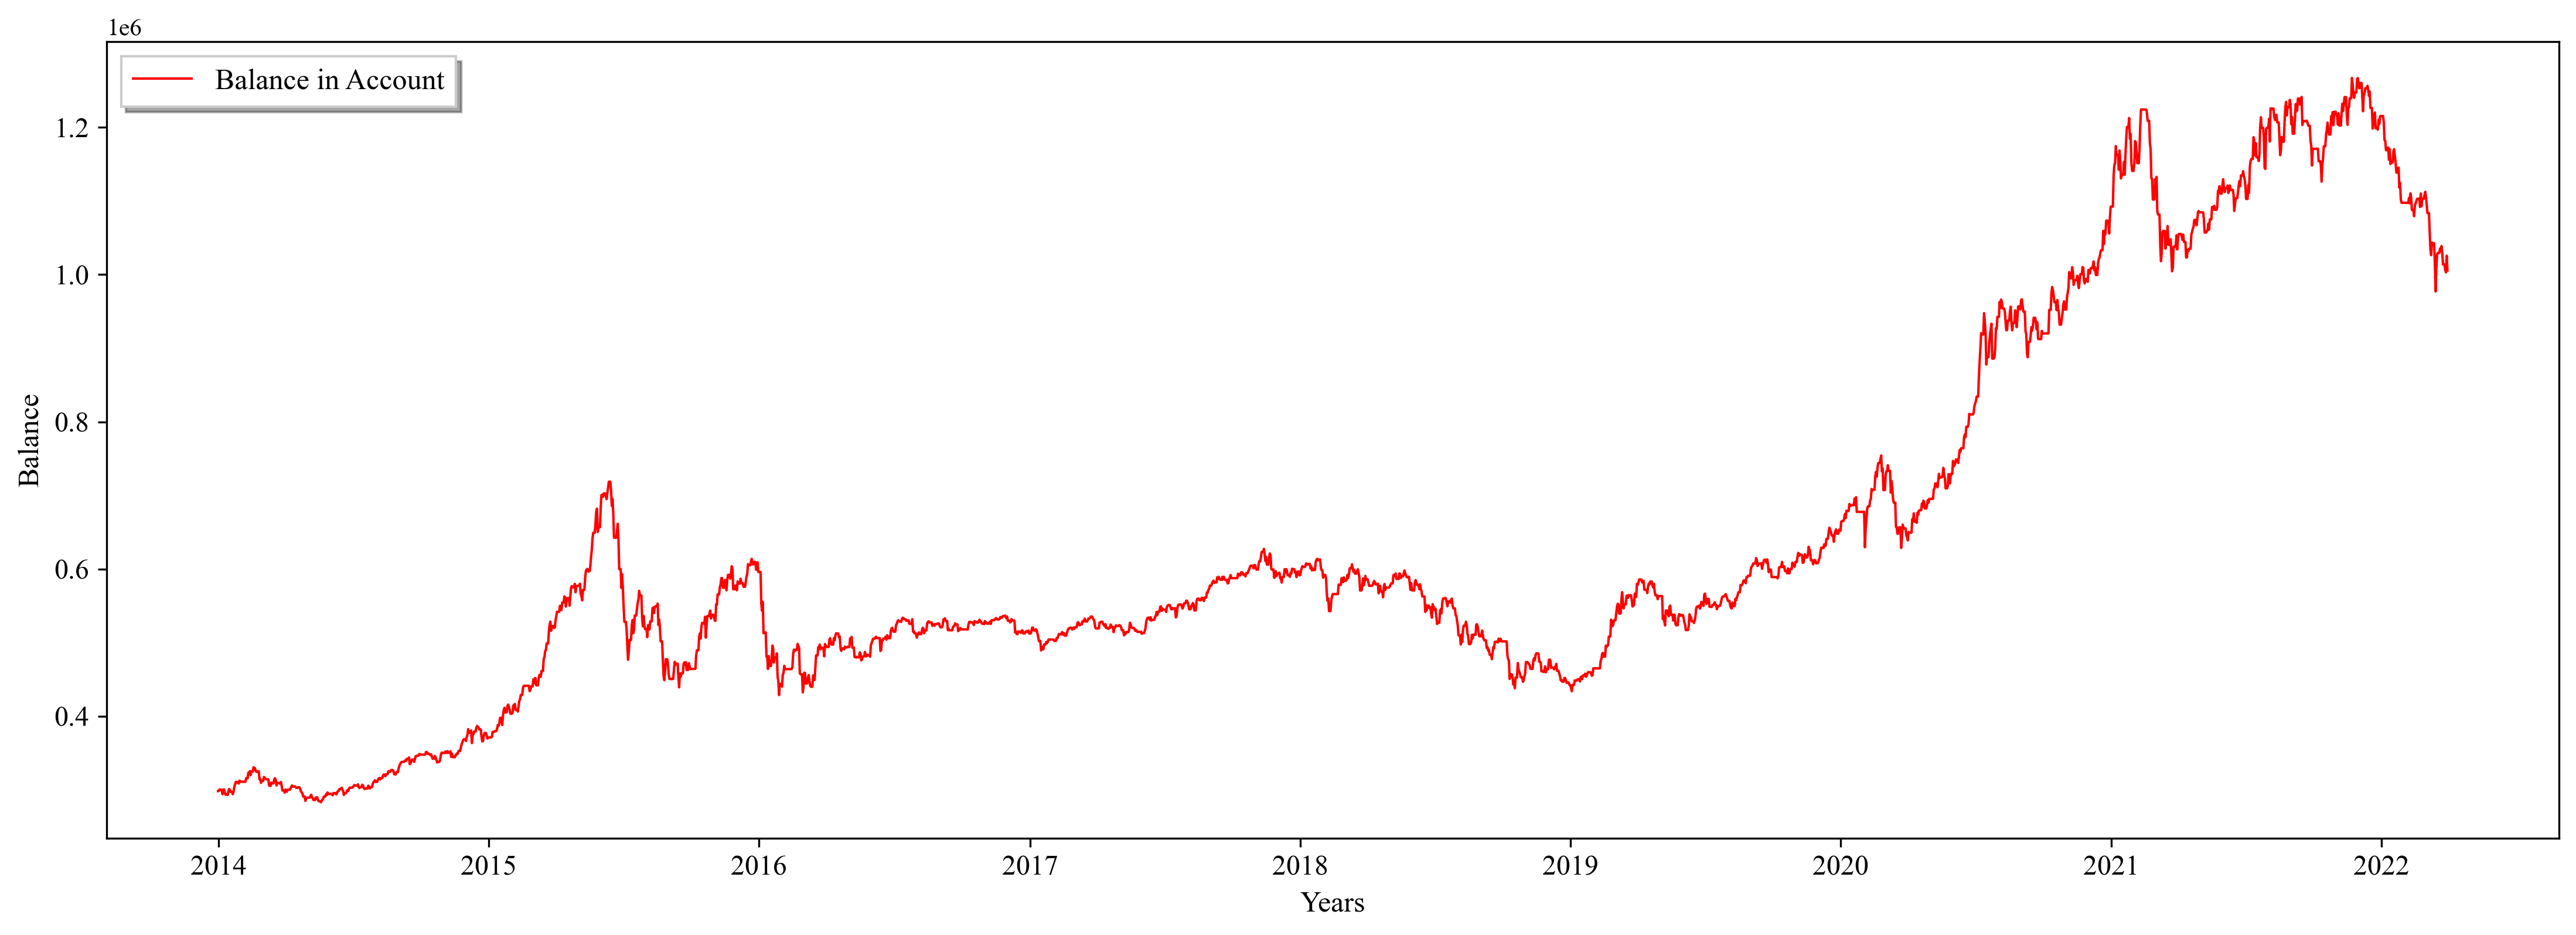

In [17]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 300)
ax1 = fig.add_subplot(111)
ax1.plot(long_backtest_result.ACCOUNT_NAV, "-",color = "red",linewidth = 1,label = "Net Value")
# ax1.plot(short_backtest_result.ACCOUNT_NAV, "-",color = "#0000FF",linewidth = 1,label = "Net Value")
# ax1.plot(300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV, "--",color = "orange",linewidth = 1,label = "Net Value")
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)
plt.savefig("./Output/BalanceInAccount(StyleIndex(all)).png")

#### 4.风险收益指标

In [18]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values, risk_free = rf, period = 'daily', annualization = 365)

0.5777727979728424

In [19]:
# annual return
empyrical.annual_return(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values,period = 'daily',annualization = 365)

0.1585629927214509

In [20]:
# max drawdown
((long_backtest_result.ACCOUNT_NAV.cummax() - long_backtest_result.ACCOUNT_NAV)/(long_backtest_result.ACCOUNT_NAV.cummax())).max()

0.4031490406975629